In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_formatted import *

In [3]:
#set to true on first run
RETRAIN=False

## Serializing the model

Store on ssd rather than in home folder

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGEWOOF_160, dest='data')

In [5]:
size = 128
bs = 64

tfms = [make_rgb, RandomResizedCrop(size, scale=(0.35,1)), np_to_float, PilRandomFlip()]
val_tfms = [make_rgb, CenterCrop(size), np_to_float]
il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
ll.valid.x.tfms = val_tfms
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=8)

In [6]:
len(il)

12954

In [7]:
loss_func = LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

Using imagenette norm on imagewoof

In [8]:
learn = cnn_learner(arch=xresnet18, data=data, loss_func=loss_func, opt_func=opt_func, norm=norm_imagenette)

In [9]:
def sched_1cycle(lr, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

In [10]:
lr = 3e-3
pct_start = 0.5
cbsched = sched_1cycle(lr, pct_start)

save out model so can use with pets

In [11]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)

if RETRAIN:
    learn.fit(40, cbsched)
    st = learn.model.state_dict()

    print(type(st))

    #keys are names of the layers
    print(', '.join(st.keys()))
    print(st['0.0.weight'])
    print(st['10.bias'])
    print(path)

    #It's also possible to save the whole model, including the architecture, 
    #but it gets quite fiddly and we don't recommend it. 
    #Instead, just save the parameters, and recreate the model directly.

    torch.save(st, mdl_path/'iw5')
else:
    print('Loading pre-trained model weights')
    learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
    st = learn.model.state_dict()
    print(st['10.bias'])

Loading pre-trained model weights
tensor([ 0.0034,  0.0257,  0.0335,  0.0067, -0.0040, -0.0165, -0.0683, -0.0110,
         0.0068,  0.0113])


## Pets

In [12]:
pets = datasets.untar_data(datasets.URLs.PETS, dest='data')

In [13]:
pets.ls()

[PosixPath('data/oxford-iiit-pet/annotations'),
 PosixPath('data/oxford-iiit-pet/images')]

In [14]:
pets_path = pets/'images'

In [15]:
il = ImageList.from_files(pets_path, tfms=tfms)

In [16]:
il

ImageList (7390 items)
[PosixPath('data/oxford-iiit-pet/images/scottish_terrier_193.jpg'), PosixPath('data/oxford-iiit-pet/images/Bengal_173.jpg'), PosixPath('data/oxford-iiit-pet/images/boxer_147.jpg'), PosixPath('data/oxford-iiit-pet/images/pug_137.jpg'), PosixPath('data/oxford-iiit-pet/images/german_shorthaired_54.jpg'), PosixPath('data/oxford-iiit-pet/images/Ragdoll_88.jpg'), PosixPath('data/oxford-iiit-pet/images/english_setter_120.jpg'), PosixPath('data/oxford-iiit-pet/images/great_pyrenees_120.jpg'), PosixPath('data/oxford-iiit-pet/images/British_Shorthair_212.jpg'), PosixPath('data/oxford-iiit-pet/images/leonberger_155.jpg')...]
Path: data/oxford-iiit-pet/images

We dont have a sapratae validation directory so randomly grab val samples

In [17]:
#export
def random_splitter(fn, p_valid): return random.random() < p_valid

In [18]:
random.seed(42)

In [19]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid=0.1))

In [20]:
sd

SplitData
Train: ImageList (6667 items)
[PosixPath('data/oxford-iiit-pet/images/scottish_terrier_193.jpg'), PosixPath('data/oxford-iiit-pet/images/boxer_147.jpg'), PosixPath('data/oxford-iiit-pet/images/pug_137.jpg'), PosixPath('data/oxford-iiit-pet/images/german_shorthaired_54.jpg'), PosixPath('data/oxford-iiit-pet/images/Ragdoll_88.jpg'), PosixPath('data/oxford-iiit-pet/images/english_setter_120.jpg'), PosixPath('data/oxford-iiit-pet/images/British_Shorthair_212.jpg'), PosixPath('data/oxford-iiit-pet/images/chihuahua_132.jpg'), PosixPath('data/oxford-iiit-pet/images/staffordshire_bull_terrier_59.jpg'), PosixPath('data/oxford-iiit-pet/images/chihuahua_127.jpg')...]
Path: data/oxford-iiit-pet/images
Valid: ImageList (723 items)
[PosixPath('data/oxford-iiit-pet/images/Bengal_173.jpg'), PosixPath('data/oxford-iiit-pet/images/great_pyrenees_120.jpg'), PosixPath('data/oxford-iiit-pet/images/leonberger_155.jpg'), PosixPath('data/oxford-iiit-pet/images/Siamese_84.jpg'), PosixPath('data/oxfor

Now need to label - use filenames as cant use folders

In [21]:
n = il.items[0].name; n

'scottish_terrier_193.jpg'

In [22]:
re.findall(r'^(.*)_\d+.jpg$', n)[0]

'scottish_terrier'

In [23]:
def pet_labeler(fn): 
    return re.findall(r'^(.*)_\d+.jpg$', fn.name)[0]

Use CategoryProcessor from last week

In [24]:
proc = CategoryProcessor()

In [25]:
ll = label_by_func(sd, pet_labeler, proc_y=proc)

In [26]:
', '.join(proc.vocab)

'scottish_terrier, boxer, pug, german_shorthaired, Ragdoll, english_setter, British_Shorthair, chihuahua, staffordshire_bull_terrier, Maine_Coon, pomeranian, american_pit_bull_terrier, yorkshire_terrier, Bengal, saint_bernard, Birman, Abyssinian, Bombay, Siamese, keeshond, beagle, american_bulldog, shiba_inu, wheaten_terrier, leonberger, basset_hound, great_pyrenees, japanese_chin, Russian_Blue, Sphynx, havanese, Egyptian_Mau, english_cocker_spaniel, samoyed, newfoundland, miniature_pinscher, Persian'

In [27]:
ll.valid.x.tfms = val_tfms

In [28]:
c_out = len(proc.vocab)

In [29]:
data = ll.to_databunch(bs, c_in=3, c_out=c_out, num_workers=8)

In [30]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, norm=norm_imagenette)

In [31]:
learn.fit(5, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,3.461437,0.089846,3.504297,0.094053,00:07
1,3.284094,0.135593,3.823331,0.112033,00:07
2,3.065019,0.194390,3.374397,0.178423,00:07
3,2.733736,0.298635,2.800860,0.298755,00:07
4,2.457302,0.386681,2.525607,0.376210,00:07


## Custom head

Poor result above, here we read in imagewoof model and customise for pets. Create 10 activations at end.

Also addpend Recorder callback to access loss

In [32]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette, xtra_cb=Recorder)

In [33]:
mdl_path

PosixPath('data/imagewoof-160/models')

In [34]:
st = torch.load(mdl_path/'iw5')

In [35]:
st.keys()

odict_keys(['0.0.weight', '0.1.weight', '0.1.bias', '0.1.running_mean', '0.1.running_var', '0.1.num_batches_tracked', '1.0.weight', '1.1.weight', '1.1.bias', '1.1.running_mean', '1.1.running_var', '1.1.num_batches_tracked', '2.0.weight', '2.1.weight', '2.1.bias', '2.1.running_mean', '2.1.running_var', '2.1.num_batches_tracked', '4.0.convs.0.0.weight', '4.0.convs.0.1.weight', '4.0.convs.0.1.bias', '4.0.convs.0.1.running_mean', '4.0.convs.0.1.running_var', '4.0.convs.0.1.num_batches_tracked', '4.0.convs.1.0.weight', '4.0.convs.1.1.weight', '4.0.convs.1.1.bias', '4.0.convs.1.1.running_mean', '4.0.convs.1.1.running_var', '4.0.convs.1.1.num_batches_tracked', '4.1.convs.0.0.weight', '4.1.convs.0.1.weight', '4.1.convs.0.1.bias', '4.1.convs.0.1.running_mean', '4.1.convs.0.1.running_var', '4.1.convs.0.1.num_batches_tracked', '4.1.convs.1.0.weight', '4.1.convs.1.1.weight', '4.1.convs.1.1.bias', '4.1.convs.1.1.running_mean', '4.1.convs.1.1.running_var', '4.1.convs.1.1.num_batches_tracked', '5.0.c

In [36]:
m = learn.model

In [37]:
mst = m.state_dict()

In [38]:
mst.keys()

odict_keys(['0.0.weight', '0.1.weight', '0.1.bias', '0.1.running_mean', '0.1.running_var', '0.1.num_batches_tracked', '1.0.weight', '1.1.weight', '1.1.bias', '1.1.running_mean', '1.1.running_var', '1.1.num_batches_tracked', '2.0.weight', '2.1.weight', '2.1.bias', '2.1.running_mean', '2.1.running_var', '2.1.num_batches_tracked', '4.0.convs.0.0.weight', '4.0.convs.0.1.weight', '4.0.convs.0.1.bias', '4.0.convs.0.1.running_mean', '4.0.convs.0.1.running_var', '4.0.convs.0.1.num_batches_tracked', '4.0.convs.1.0.weight', '4.0.convs.1.1.weight', '4.0.convs.1.1.bias', '4.0.convs.1.1.running_mean', '4.0.convs.1.1.running_var', '4.0.convs.1.1.num_batches_tracked', '4.1.convs.0.0.weight', '4.1.convs.0.1.weight', '4.1.convs.0.1.bias', '4.1.convs.0.1.running_mean', '4.1.convs.0.1.running_var', '4.1.convs.0.1.num_batches_tracked', '4.1.convs.1.0.weight', '4.1.convs.1.1.weight', '4.1.convs.1.1.bias', '4.1.convs.1.1.running_mean', '4.1.convs.1.1.running_var', '4.1.convs.1.1.num_batches_tracked', '5.0.c

In [39]:
#check that keys are same in both dicts

In [40]:
[k for k in st.keys() if k not in mst.keys()]

[]

In [41]:
m.load_state_dict(st)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [42]:
#want to remove last layer as have different ammount of categries - here 37 pet breeds. Find the AdaptiveAvgPool2d layer and use everything before this

In [43]:
m

XResNet(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [44]:
cut = next(i for i,o in enumerate(m.children()) if isinstance(o,nn.AdaptiveAvgPool2d))
m_cut = m[:cut]

In [45]:
len(m_cut)

8

In [46]:
xb,yb = get_batch(data.valid_dl, learn)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


In [47]:
pred = m_cut(xb)

In [48]:
pred.shape

torch.Size([128, 512, 4, 4])

To find number of inputs, here we have 128 minibatch of input size 512, 4x4

In [49]:
#number of inputs to our head
ni = pred.shape[1]

Note we use both Avg and Max pool and concatenate them together eg
https://www.cs.cmu.edu/~tzhi/publications/ICIP2016_two_stage.pdf

In [50]:
#export
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=1):
        super().__init__()
        self.output_size = sz
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [51]:
nh = 40

m_new = nn.Sequential(
    m_cut, AdaptiveConcatPool2d(), Flatten(),
    nn.Linear(ni*2, data.c_out))

In [52]:
learn.model = m_new

#### stat and plot functions

In [53]:
def append_hist_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): 
        hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    if mod.training:
        means.append(outp.data.mean().cpu())
        stds .append(outp.data.std().cpu())
        hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [54]:
def plot_hooks(hooks):
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    print(f'plotting {len(hooks)} layers')
    for h in hooks:
        ms,ss, hists = h.stats
        ax0.plot(ms)
        ax0.set_title('mean')
        ax1.plot(ss)
        ax1.set_title('std. dev.')
    plt.legend(range(len(hooks)));

In [55]:
#get the hist data at index 2
def get_hist(h): 
    assert len(h.stats)==3
    return torch.stack(h.stats[2]).t().float().log1p().cpu()

In [56]:
def plot_hooks_hist(hooks):
    fig,axes = plt.subplots(2,2, figsize=(15,6))
    for ax,h in zip(axes.flatten(), hooks):
        ax.imshow(get_hist(h), origin='lower')
        ax.imshow(get_hist(h))
        ax.set_aspect('auto')
        ax.axis('on')
    plt.tight_layout()

In [57]:
def plot_hooks_hist_lines(hooks):
    fig,axes = plt.subplots(2,2, figsize=(15,10))
    for ax,h in zip(axes.flatten(), hooks):
        ax.plot(get_hist(h))
        ax.axis('on')

In [58]:
def get_start_mins(h, total_bins):
    h1 = torch.stack(h.stats[2]).t().float().cpu()
    return h1[:2].sum(0)/h1.sum(0)

In [59]:
def get_mid_mins(h, total_bins):
    h1 = torch.stack(h.stats[2]).t().float().cpu()
    #get stats on middle bins of histogram data
    return h1[int((total_bins/2)-1):int((total_bins/2)+2)].sum(0)/h1.sum(0)

In [60]:
def plot_mins(hooks):
    fig,axes = plt.subplots(2,2, figsize=(15,6))
    hist = get_hist(hooks[0])
    total_bins=hist.shape[1]
    print(total_bins)
    for ax,h in zip(axes.flatten(), hooks[:4]):
        ax.plot(get_start_mins(h,total_bins))
        ax.plot(get_mid_mins(h,total_bins))
        ax.set_ylim(0,1)
        ax.axis('on')
    plt.tight_layout()
    plt.legend(['start','mid'])

In [61]:
def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = ep_vals.keys()
    plt.xticks(np.asarray(list(epochs)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    val_losses = [item[1] for item in list(ep_vals.values())]
    plt.plot(epochs, trn_losses, c='b', label='train')
    plt.plot(epochs, val_losses, c='r', label='validation')
    plt.legend(loc='upper left')

### Fit

In [62]:
with Hooks(learn.model, append_hist_stats) as hooks_naive: 
    learn.fit(5, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.891422,0.287236,2.187882,0.468880,00:08
1,2.034565,0.515974,2.067969,0.515906,00:08
2,1.834229,0.595470,1.850442,0.580913,00:08
3,1.592351,0.687866,1.572849,0.683264,00:08
4,1.398077,0.769612,1.498307,0.717842,00:08


plotting 4 layers


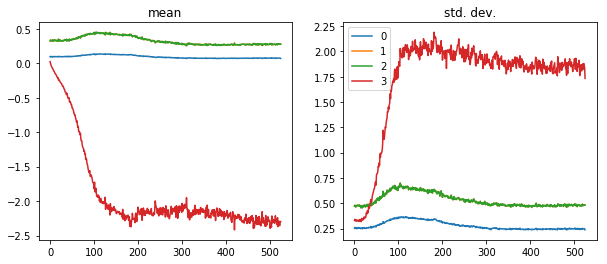

In [63]:
plot_hooks(hooks_naive)

#### Histograms

In [64]:
hooks_naive

Hooks (4 items)
[<exp.nb_formatted.Hook object at 0x7fd6051c11d0>, <exp.nb_formatted.Hook object at 0x7fd6051c1278>, <exp.nb_formatted.Hook object at 0x7fd6051c1160>, <exp.nb_formatted.Hook object at 0x7fd6051c14a8>]

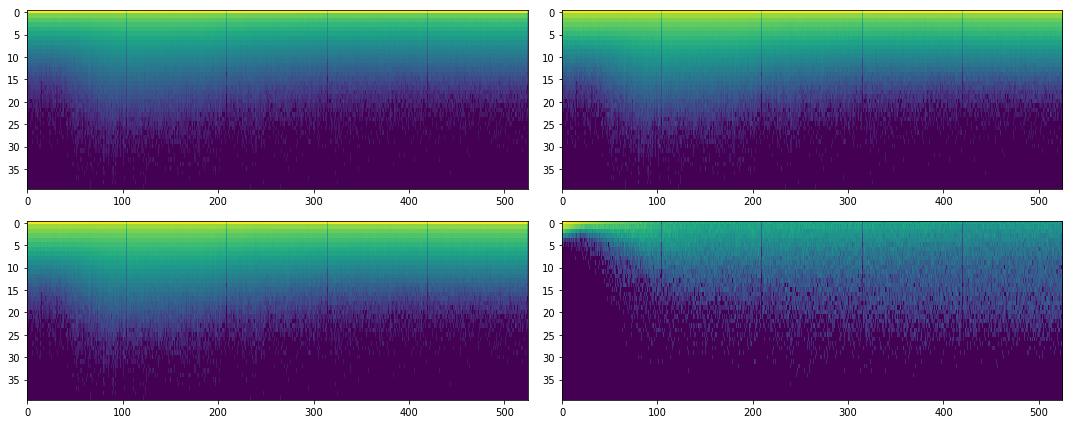

In [65]:
plot_hooks_hist(hooks_naive)

525


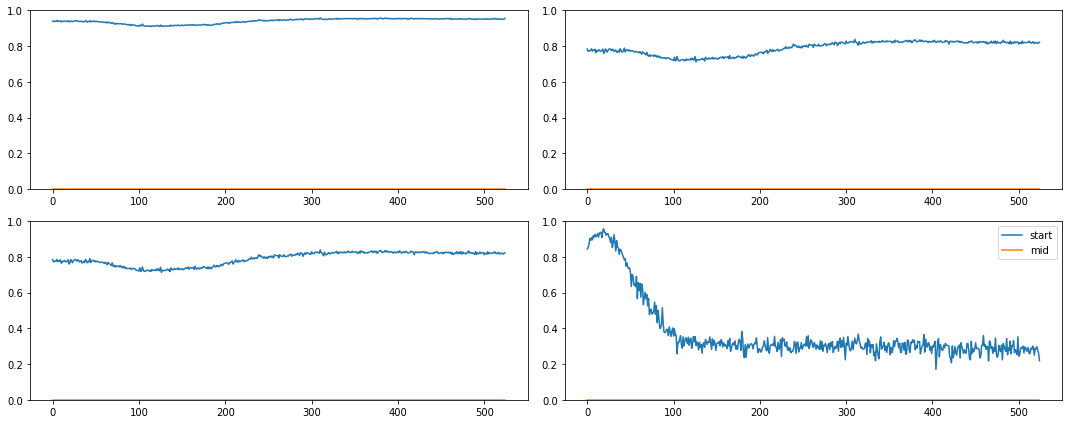

In [66]:
plot_mins(hooks_naive)

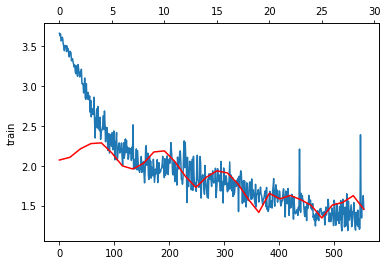

In [67]:
learn.recorder.plot_loss()

In [68]:
len(learn.recorder.losses)/len(learn.recorder.val_losses)

18.5

In [ ]:
#18.5 * more training data than validation data 

## adapt_model and gradual unfreezing

Lines above pasted into one cell to create a function (Shift-M)

In [81]:
def adapt_model(learn, data):
    cut = next(i for i,o in enumerate(learn.model.children())
               if isinstance(o,nn.AdaptiveAvgPool2d))
    m_cut = learn.model[:cut]
    xb,yb = get_batch(data.valid_dl, learn)
    pred = m_cut(xb)
    ni = pred.shape[1]
    m_new = nn.Sequential(
        m_cut, AdaptiveConcatPool2d(), Flatten(),
        nn.Linear(ni*2, data.c_out))
    learn.model = m_new

In [82]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette, xtra_cb=Recorder)
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [83]:
adapt_model(learn, data)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


In [84]:
len(learn.model)

4

Grab all parameters in the body (the m_cut bit) and dont train these - just train the head

#### Freeze everything before head

In [85]:
for p in learn.model[0].parameters(): p.requires_grad_(False)

In [86]:
with Hooks(learn.model, append_hist_stats) as hooks_freeze: 
    learn.fit(3, sched_1cycle(1e-2, 0.5))

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.705802,0.321134,2.474566,0.426003,00:06
1,2.413762,0.436628,2.218618,0.500692,00:06
2,2.061560,0.529774,1.994902,0.562932,00:06


plotting 4 layers


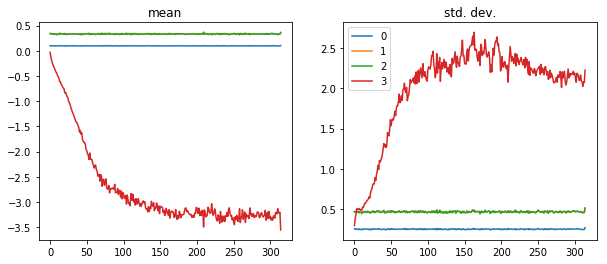

In [87]:
plot_hooks(hooks_freeze)

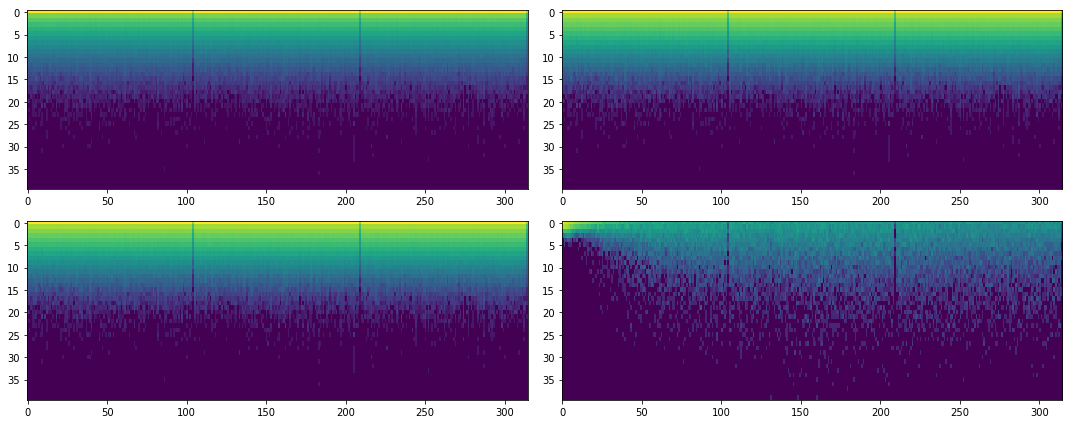

In [88]:
plot_hooks_hist(hooks_freeze)

315


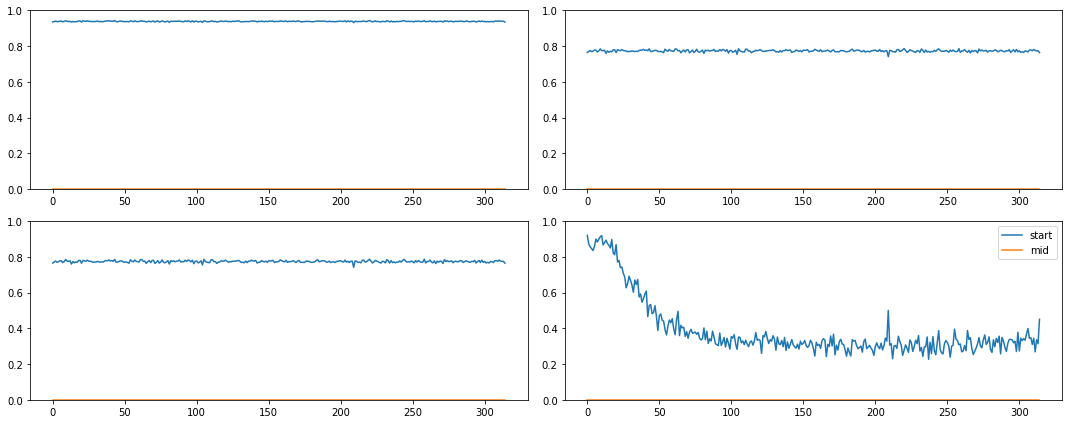

In [89]:
plot_mins(hooks_freeze)

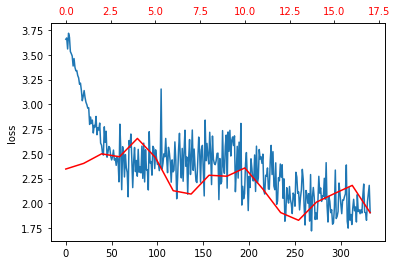

In [90]:
learn.recorder.plot_loss()

#### Unfreeze

In [91]:
for p in learn.model[0].parameters(): p.requires_grad_(True)

In [92]:
with Hooks(learn.model, append_hist_stats) as hooks_unfreeze: 
    learn.fit(5, cbsched, reset_opt=True)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.841855,0.605070,1.928303,0.578147,00:08
1,1.757191,0.626219,1.904582,0.558783,00:08
2,1.728981,0.640918,1.867575,0.607192,00:08
3,1.535111,0.714114,1.591264,0.684647,00:08
4,1.357730,0.794510,1.511411,0.730290,00:08


With freeze then unfreeze I'm getting slightly better than naive training.
In frozen layer - train for particuar mean and std dev, but pets has different std dev and means inside the model.

What is really going on here? (1:26 in lesson video), and why do I get better results when JH got worse result?

plotting 4 layers


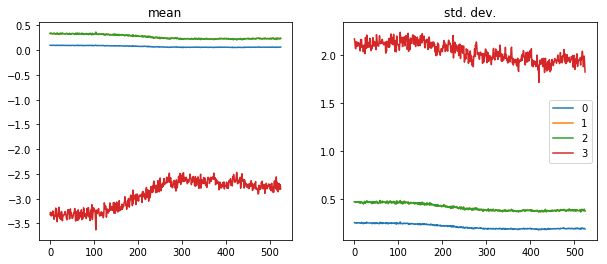

In [93]:
plot_hooks(hooks_unfreeze)

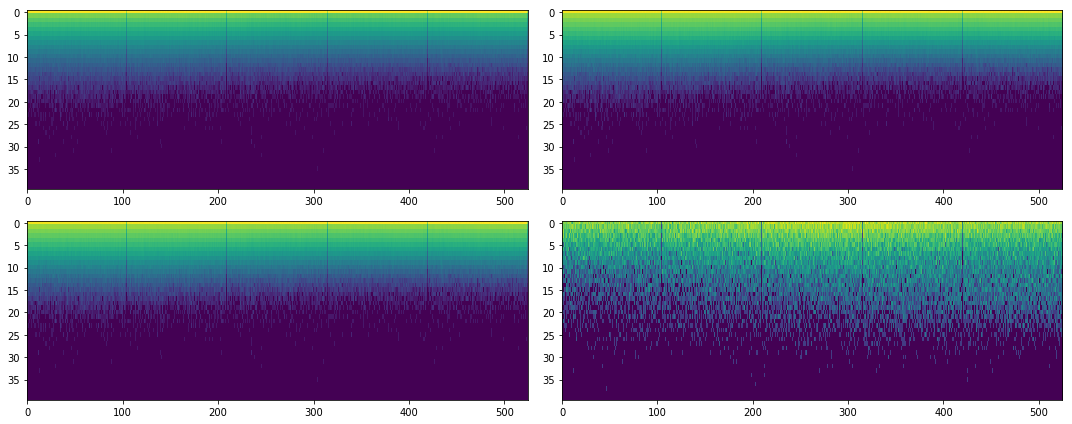

In [94]:
plot_hooks_hist(hooks_unfreeze)

525


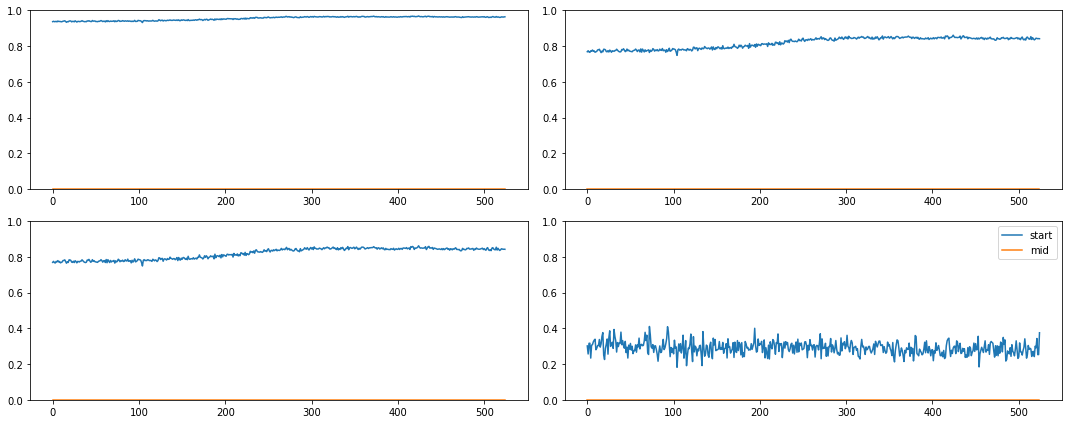

In [95]:
plot_mins(hooks_unfreeze)

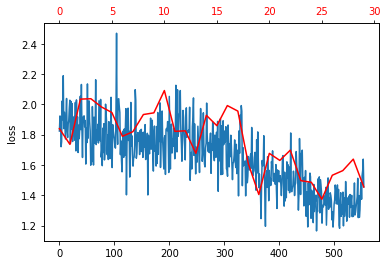

In [96]:
learn.recorder.plot_loss()

Freeze only layer params that aren't in the batch norm layers

1:27 in lesson 12

## Batch norm transfer

In [101]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette, xtra_cb=Recorder)
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
adapt_model(learn, data)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


In [102]:
def apply_mod(m, f):
    f(m)
    for l in m.children(): apply_mod(l, f)

def set_grad(m, b):
    #if linear layr at end of batchnorm layer in middle, dont change the gradient
    if isinstance(m, (nn.Linear,nn.BatchNorm2d)): return
    if hasattr(m, 'weight'):
        for p in m.parameters(): p.requires_grad_(b)

#### Freeze and fit

Freeze just non batchnorm and last layer

In [103]:
apply_mod(learn.model, partial(set_grad, b=False))

In [104]:
with Hooks(learn.model, append_hist_stats) as hooks_freeze_non_bn: 
    learn.fit(3, sched_1cycle(1e-2, 0.5))

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.646974,0.331783,2.228704,0.478562,00:06
1,2.104910,0.501875,1.988791,0.562932,00:06
2,1.845815,0.594120,1.814245,0.608575,00:06


plotting 4 layers


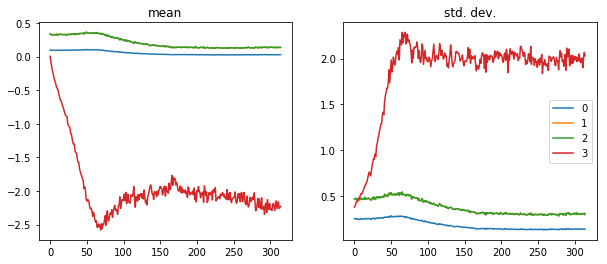

In [105]:
plot_hooks(hooks_freeze_non_bn)

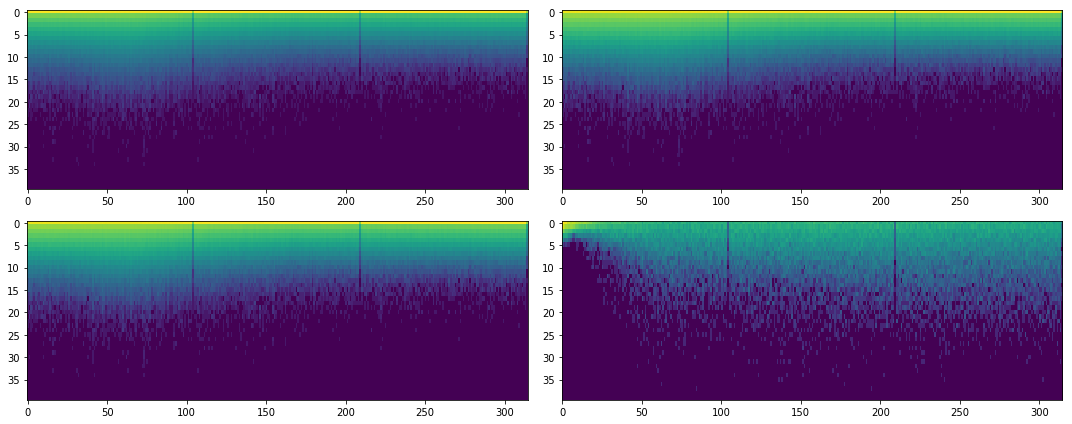

In [106]:
plot_hooks_hist(hooks_freeze_non_bn)

315


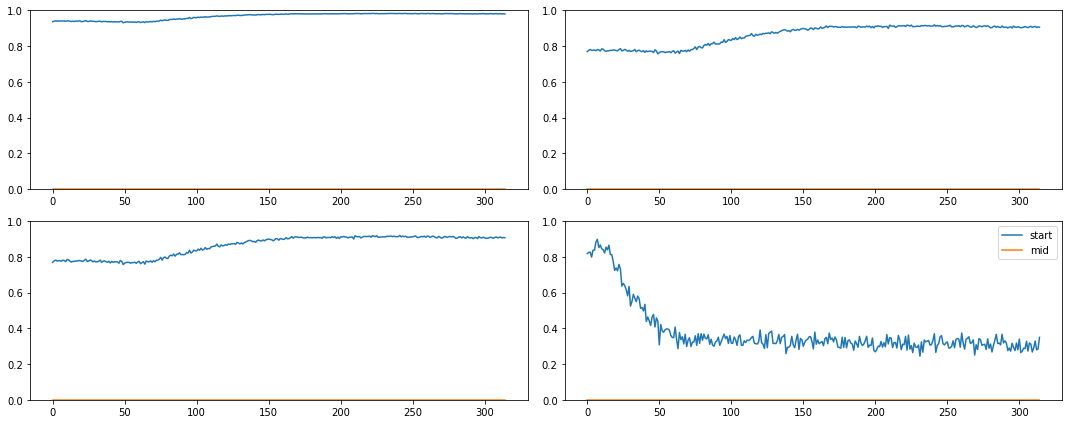

In [107]:
plot_mins(hooks_freeze_non_bn)

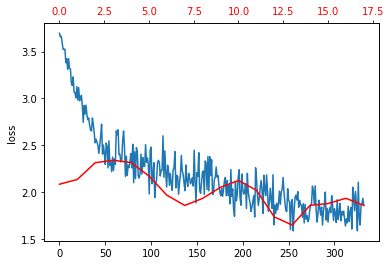

In [108]:
learn.recorder.plot_loss()

#### Unfreeze

In [111]:
apply_mod(learn.model, partial(set_grad, b=True))

In [112]:
with Hooks(learn.model, append_hist_stats) as hooks_unfreeze_non_bn: 
    learn.fit(5, cbsched, reset_opt=True)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.730774,0.640768,1.816925,0.603043,00:08
1,1.719807,0.642118,1.813902,0.600277,00:08
2,1.682662,0.654567,1.818971,0.626556,00:08
3,1.532454,0.712764,1.594608,0.692946,00:08
4,1.340358,0.798110,1.527948,0.731674,00:08


plotting 4 layers


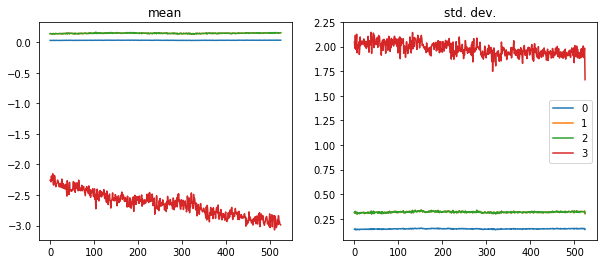

In [113]:
plot_hooks(hooks_unfreeze_non_bn)

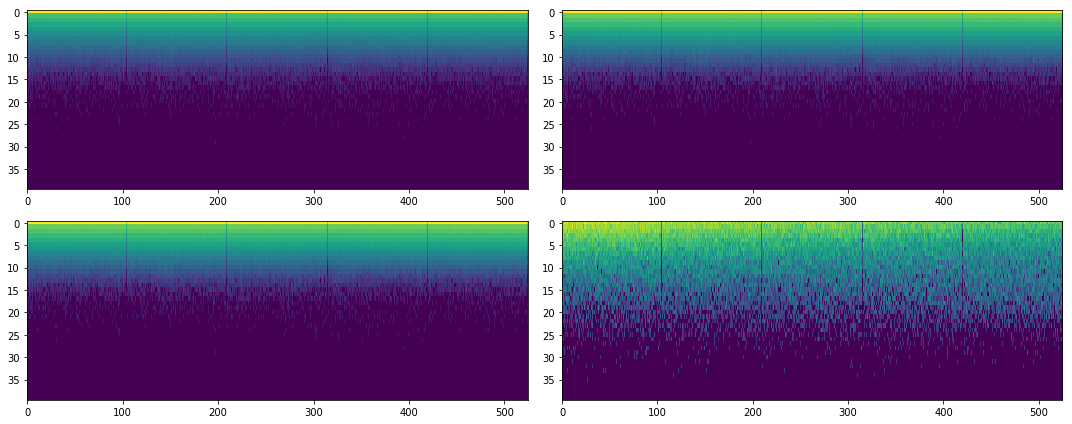

In [114]:
plot_hooks_hist(hooks_unfreeze_non_bn)

525


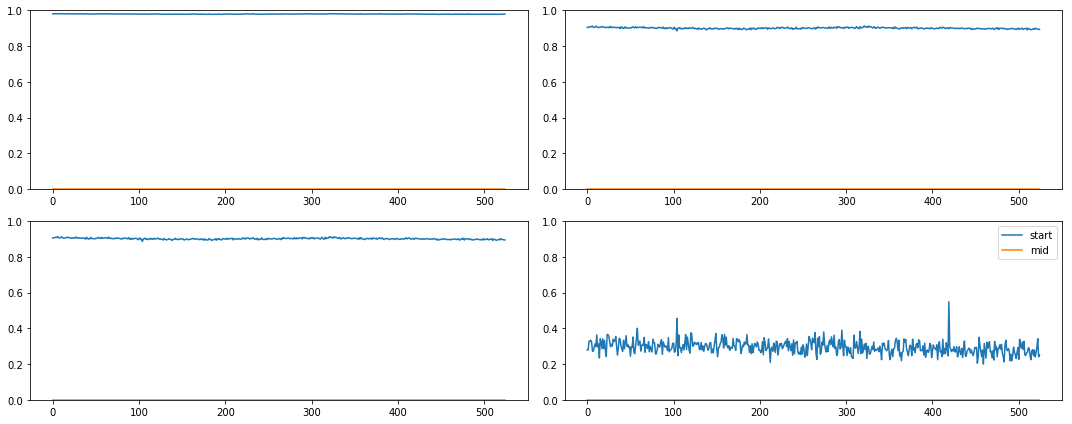

In [115]:
plot_mins(hooks_unfreeze_non_bn)

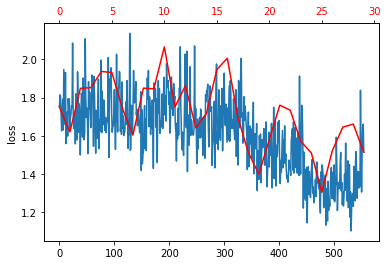

In [116]:
learn.recorder.plot_loss()

Pytorch already has an `apply` method we can use:

In [121]:
learn.model.apply(partial(set_grad, b=False));

Lesson 12 video: 1:29

## Discriminative LR and param groups

In [122]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func, c_out=10, norm=norm_imagenette)

In [123]:
learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
adapt_model(learn, data)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


In [ ]:
def bn_splitter(m):
    def _bn_splitter(l, g1, g2):
        if isinstance(l, nn.BatchNorm2d): g2 += l.parameters()
        elif hasattr(l, 'weight'): g1 += l.parameters()
        for ll in l.children(): _bn_splitter(ll, g1, g2)
        
    g1,g2 = [],[]
    _bn_splitter(m[0], g1, g2)
    
    g2 += m[1:].parameters()
    return g1,g2

In [ ]:
a,b = bn_splitter(learn.model)

In [ ]:
test_eq(len(a)+len(b), len(list(m.parameters())))

In [ ]:
Learner.ALL_CBS

In [ ]:
#export
from types import SimpleNamespace
cb_types = SimpleNamespace(**{o:o for o in Learner.ALL_CBS})

In [ ]:
cb_types.after_backward

In [ ]:
#export
class DebugCallback(Callback):
    _order = 999
    def __init__(self, cb_name, f=None): self.cb_name,self.f = cb_name,f
    def __call__(self, cb_name):
        if cb_name==self.cb_name:
            if self.f: self.f(self.run)
            else:      set_trace()

In [ ]:
#export
def sched_1cycle(lrs, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = [combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
                 for lr in lrs]
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

In [ ]:
disc_lr_sched = sched_1cycle([0,3e-2], 0.5)

In [ ]:
learn = cnn_learner(xresnet18, data, loss_func, opt_func,
                    c_out=10, norm=norm_imagenette, splitter=bn_splitter)

learn.model.load_state_dict(torch.load(mdl_path/'iw5'))
adapt_model(learn, data)

In [ ]:
def _print_det(o): 
    print (len(o.opt.param_groups), o.opt.hypers)
    raise CancelTrainException()

learn.fit(1, disc_lr_sched + [DebugCallback(cb_types.after_batch, _print_det)])

In [ ]:
learn.fit(3, disc_lr_sched)

In [ ]:
disc_lr_sched = sched_1cycle([1e-3,1e-2], 0.3)

In [ ]:
learn.fit(5, disc_lr_sched)

## Export

In [ ]:
!./notebook2script.py 11a_transfer_learning.ipynb